# Previsão de churn (abandono) em telecom

### Referências:
- https://github.com/RomeroBarata/IF702-redes-neurais

### Grupo 8:
- Erbert Gadelha (ebgr)
- João Pedro (jpba)
- Vinicius Barbosa (vrb)
- Almir Alves (aasc)
- Felipe Mateus (fmfb)

# Preparação e importação da base de dados

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
#@title Download data and create DataFrame
churn_data_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", churn_data_path)

churn_df = pd.read_csv(churn_data_path + "/customer_churn_telecom_services.csv")
print(f"Data shape {churn_df.shape}")
churn_df.head()

Path to dataset files: /kaggle/input/customers-churned-in-telecom-services
Data shape (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploração dos dados

### Descrição das colunas:

| Column Name | Description |
|-------------|-------------|
| gender | Customer's gender (Male/Female) |
| SeniorCitizen |	Indicates if the customer is a senior citizen (1 = Yes, 0 = No) |
| Partner | Whether the customer has a partner (Yes/No) |
| Dependents | Whether the customer has dependents (Yes/No) |
|tenure |	Number of months the customer has stayed with the company |
|PhoneService |	Whether the customer has a phone service (Yes/No) |
|MultipleLines | Whether the customer has multiple phone lines (No, Yes, No phone service) |
|InternetService | Type of internet service (DSL, Fiber optic, No) |
|OnlineSecurity |	Whether the customer has online security (Yes, No, No internet service) |
|OnlineBackup |	Whether the customer has online backup (Yes, No, No internet service) |
|DeviceProtection |	Whether the customer has device protection (Yes, No, No internet service) |
|TechSupport | Whether the customer has tech support (Yes, No, No internet service) |
|StreamingTV | Whether the customer has streaming TV (Yes, No, No internet service) |
|StreamingMovies |	Whether the customer has streaming movies (Yes, No, No internet service) |
|Contract |	Type of contract (Month-to-month, One year, Two year) |
|PaperlessBilling |	Whether the customer has paperless billing (Yes/No) |
|PaymentMethod | Payment method used (Electronic check, Mailed check, Bank transfer, Credit card) |
|MonthlyCharges |	Monthly charges the customer pays |
|TotalCharges |	Total amount charged to the customer |
|Churn |	Whether the customer has churned (Yes/No) |

## Verificando valores nulos

In [3]:
#@title Verificando o dataset
churn_df.info()
nulls = churn_df['TotalCharges'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


A colunas `TotalCharges` possui 11 valores nulos, portanto essas amostras serão removidas.

In [4]:
#@title Removendo valores nulos
print(f"Data shape (before cleaning) {churn_df.shape}")
churn_df = churn_df.dropna()
print(f"Data shape (after cleaning) {churn_df.shape}")

Data shape (before cleaning) (7043, 20)
Data shape (after cleaning) (7032, 20)


## Verificando outliers

In [ ]:
#TODO

## Analisando distribuições

### Features Contínuas

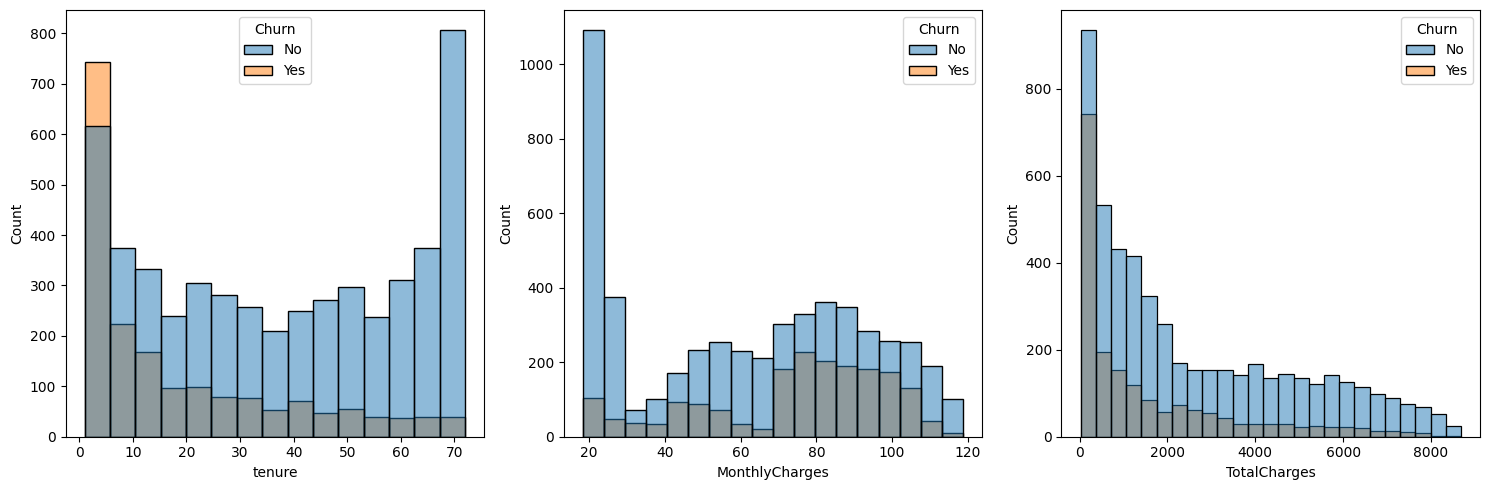

In [5]:
#@title Histograma por abandono

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.histplot(churn_df, x=feature, ax=axes[i], hue='Churn')
plt.tight_layout()
plt.show()

A partir das distribuições podemos deduzir os seguintes pontos:
*   Clientes jovens tendem a abandonar mais, enquanto pessoas com mais idade tendem a continuar sendo clientes
*   Cobranças mensais muito baixas contribuem para uma alta taxa de fidelidade, mas valores mais altos não apresentam uma influência notável



# Preparação dos dados

In [6]:
#@title Convertendo tipos categóricos

cat_df = churn_df.select_dtypes(include=['object', 'category'])
for col in cat_df.columns:
  churn_df[col] = churn_df[col].astype('category')
  churn_df[col] = churn_df[col].cat.codes

  if col == 'Churn':
    continue

  # one hot encode if more than 2 alternatives
  if len(churn_df[col].unique()) > 2:
    churn_df = pd.concat([churn_df, pd.get_dummies(churn_df[col], prefix=col)], axis=1)
    churn_df = churn_df.drop(columns=[col])

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7032 non-null   int8   
 1   SeniorCitizen       7032 non-null   int64  
 2   Partner             7032 non-null   int8   
 3   Dependents          7032 non-null   int8   
 4   tenure              7032 non-null   int64  
 5   PhoneService        7032 non-null   int8   
 6   PaperlessBilling    7032 non-null   int8   
 7   MonthlyCharges      7032 non-null   float64
 8   TotalCharges        7032 non-null   float64
 9   Churn               7032 non-null   int8   
 10  MultipleLines_0     7032 non-null   bool   
 11  MultipleLines_1     7032 non-null   bool   
 12  MultipleLines_2     7032 non-null   bool   
 13  InternetService_0   7032 non-null   bool   
 14  InternetService_1   7032 non-null   bool   
 15  InternetService_2   7032 non-null   bool   
 16  OnlineSecur

In [7]:
#@title Divisão estratificada Treino / Validação / Teste (60% / 20% / 20%)
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

print(f"Train shape {X_train.shape}")
print(f"Validation shape {X_val.shape}")
print(f"Test shape {X_test.shape}")

Train shape (4218, 40)
Validation shape (1407, 40)
Test shape (1407, 40)


In [17]:
#@title Normalização das features numéricas

mean_train = X_train.mean()
std_train = X_train.std()

X_train_n = X_train.copy(deep=True)
X_val_n = X_val.copy(deep=True)
X_test_n = X_test.copy(deep=True)

for col in numerical_features:
  X_train_n[col] = (X_train[col] - mean_train[col]) / std_train[col]
  X_val_n[col] = (X_val[col] - mean_train[col]) / std_train[col]
  X_test_n[col] = (X_test[col] - mean_train[col]) / std_train[col]

print("===========================================================================")
print("Distribuições do conjunto de treino")
print("===========================================================================")
print(X_train.describe())
print("===========================================================================")
print("Distribuições (normalizadas) do conjunto de treino")
print("===========================================================================")
print(X_train_n.describe())

Distribuições do conjunto de treino
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  4218.000000    4218.000000  4218.000000  4218.000000  4218.000000   
mean      0.499526       0.161925     0.486486     0.301091    32.402798   
std       0.500059       0.368426     0.499877     0.458786    24.487455   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       0.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  
count   4218.000000       4218.000000     4218.000000   4218.000000  
mean       0.900901          0.596254       65.045472   2281.006152  
std        0.298830          0.490706       29.876543   2251.557578  

# Execução inicial com classificadores

## MLP

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

## Random Forest

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

# Otimizando classificadores iniciais

## MLP

## Random Forest

# Executando mais classificadores

## STab

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

## TabPFN2 Transformer

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

## Gradient Boosting

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

# Avaliação final

## Comparação de métricas de todos os modelos